In [16]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
import seaborn as sns
from pymc import HalfCauchy, Model, Normal, sample

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.6.1


In [2]:
from pipeline import import_data, base_process_data, feature_normalization, ensemble_predict, temporal_process_data
from utils import cd_root_dir, save2Vis

In [3]:
cd_root_dir()

current directory: /home/yuchen/work_leslie/KTP_Croud


In [4]:
# %config InlineBackend.figure_format = 'retina'
# # Initialize random number generator
RANDOM_SEED = 9527
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [5]:
# import the data and get the time axis !
dataset, time_axis = import_data(path='data/raw/weekly_media_sample.csv')

In [6]:
# normalized features
n_train_features, n_test_features, train_labels, test_labels = base_process_data(dataset=dataset, split_index=200, normalize=True)

In [7]:
dataset.head()

,revenue,media1_S,media2_S,media3_S,competitor_sales,newsletter
0,2.754372,167687.6,95463.66667,228213.98740,8125009,19401.65
1,2.584277,214600.9,0.00000,34258.57351,7901549,14791.00
2,2.547387,0.0,3404.00000,127691.26130,8300197,14544.00
3,2.875220,625877.3,132600.00000,84014.72031,8122883,2800.00
4,2.215953,0.0,0.00000,20687.47816,7105985,15478.00


# generic weakly informative

- without prior information; set up generic weakly informative prior as standard gaussian

In [13]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = Normal("sigma", 0, sigma=10)
    
    b1 = Normal("media1_S", 0, sigma=1)
    b2 = Normal("media2_S", 0, sigma=1)
    b3 = Normal("media3_S", 0, sigma=1)
    b_cs = Normal("competitor_sales", 0, sigma=1)
    b_nl = Normal("newsletter", 0, sigma=1)
    bias = Normal("bias", 0, sigma=1)

    # Define likelihood
    likelihood = Normal("revenue", 
                        mu = bias +b1*n_train_features[:,0]+b2*n_train_features[:,1]+b3*n_train_features[:,2]+b_cs*n_train_features[:,3]+b_nl*n_train_features[:,4], 
                        sigma=sigma, 
                        observed=train_labels)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, media1_S, media2_S, media3_S, competitor_sales, newsletter, bias]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 164 seconds.


In [14]:
# idata.mean_tree_accept.mean()

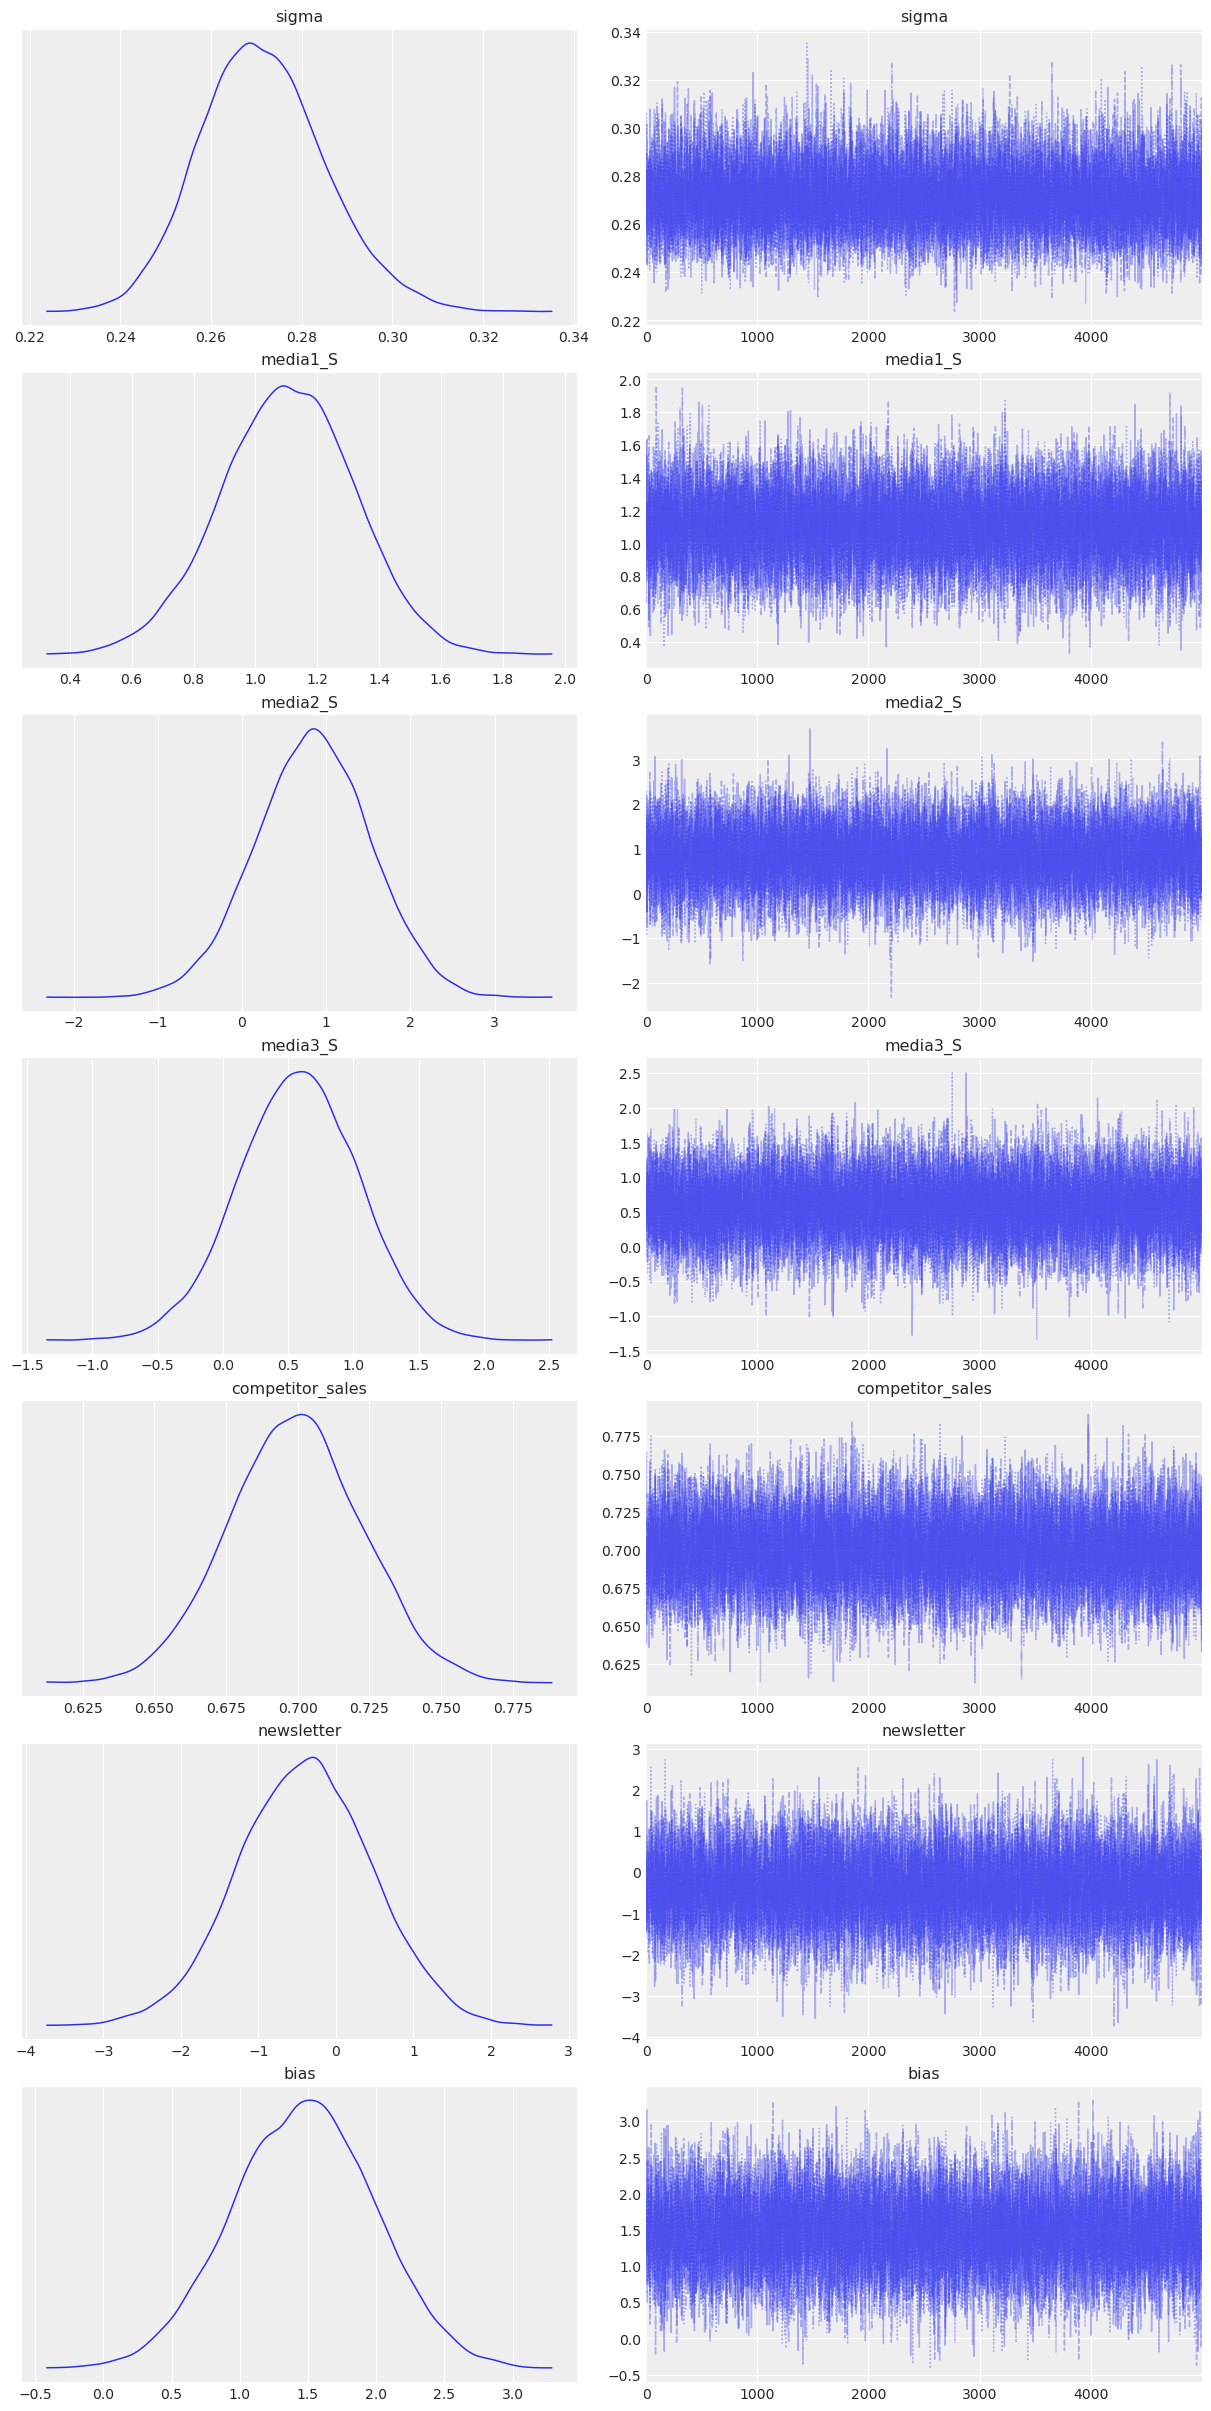

In [15]:
az.plot_trace(idata, combined=True, figsize=(12, 24));

In [ ]:
# .mean_tree_accept.mean()

# 2b-1

- If the expert is rather certain that `Media 3` has no impact, I'd therefore put a informative prior distribution that puts majority of density around 0. For example, $\mathcal{N}(\mu=0, \sigma^2 = 0.04)$. with a $\sigma=0.2$. As such, roughly 95% density will be in the range of (-0.4, 0.4).

# 2b-2

In [8]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = Normal("sigma", 0, sigma=10)
    b1 = Normal("media1_S", 0, sigma=1)
    b2 = Normal("media2_S", 0, sigma=1)
    b3 = Normal("media3_S", 0, sigma=0.2)
    b_cs = Normal("competitor_sales", 0, sigma=1)
    b_nl = Normal("newsletter", 0, sigma=1)
    bias = Normal("bias", 0, sigma=1)

    # Define likelihood
    likelihood = Normal("revenue", 
                        mu = bias +b1*n_train_features[:,0]+b2*n_train_features[:,1]+b3*n_train_features[:,2]+b_cs*n_train_features[:,3]+b_nl*n_train_features[:,4], 
                        sigma=sigma, 
                        observed=train_labels)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    trace_2 = sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, media1_S, media2_S, media3_S, competitor_sales, newsletter, bias]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 160 seconds.


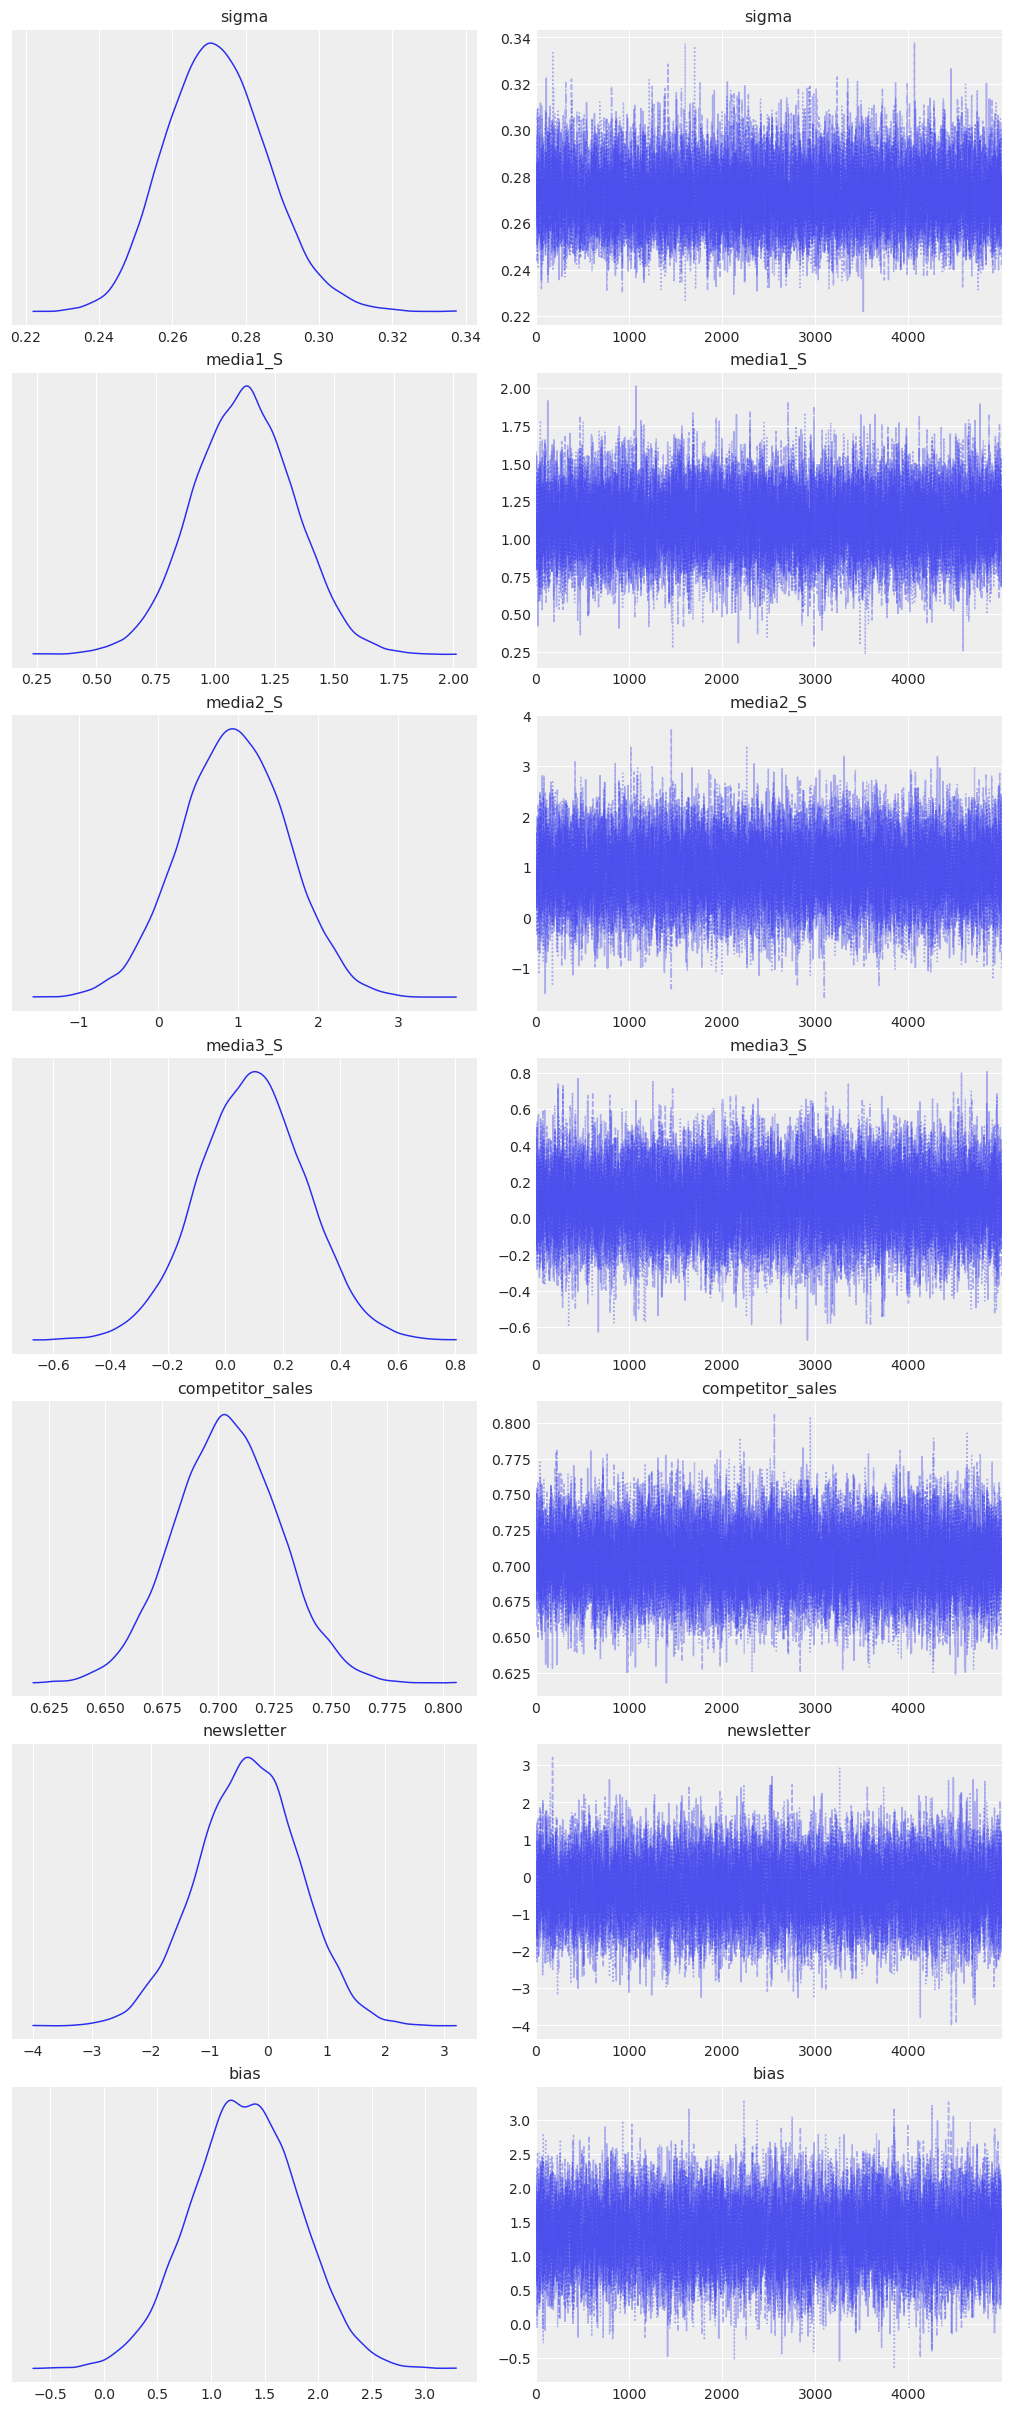

In [9]:
az.plot_trace(trace_2, combined=True, figsize=(10, 24));

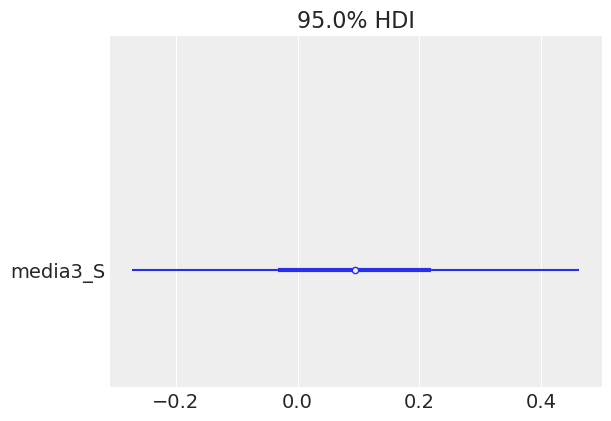

In [12]:
az.plot_forest(trace_2, var_names=["media3_S"], combined=True, hdi_prob=0.95, r_hat=False);
save2Vis('media3_effect')

# 2b-3

- Strictly positive relationship suggests positive coefficient $\beta_{nl}$. As such, I will choose a **half-Gussian prior distribution**
- “I am **fairly certain** that one unit invested in Media 1 will result in two units of marketing revenues returned.”, ergo 
$\beta_{m1} \sim \mathcal{N}(2, 0.04)$ with $\sigma=0.2$

- I believe the impact of Media 2 is four times that of what I specified for Media 1. Ergo, $\beta_{m2} \sim N(8, 0.25)$

- For every unit increase in competitor_sales, the change on revenues returned must range between 0 and 0.3. Ergo, a truncated distribution ..

In [25]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = Normal("sigma", 0, sigma=10)
    
    b1 = Normal("media1_S", 2, sigma=0.2)
    b2 = Normal("media2_S", 8, sigma=0.5)
    b3 = Normal("media3_S", 0, sigma=0.2)
    # b_cs = pm.TruncatedNormal('competitor_sales', mu=0, sigma=1, lower=0, upper=0.3)
    b_cs = pm.Uniform('competitor_sales', upper=0.3)
    
    b_nl = pm.HalfNormal('newsletter', sigma=1)
    bias = Normal("bias", 0, sigma=1)

    # Define likelihood
    likelihood = Normal("revenue", 
                        mu = bias +b1*n_train_features[:,0]+b2*n_train_features[:,1]+b3*n_train_features[:,2]+b_cs*n_train_features[:,3]+b_nl*n_train_features[:,4], 
                        sigma=sigma, 
                        observed=train_labels)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    trace_3 = sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, media1_S, media2_S, media3_S, competitor_sales, newsletter, bias]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 68 seconds.
There were 724 divergences after tuning. Increase `target_accept` or reparameterize.


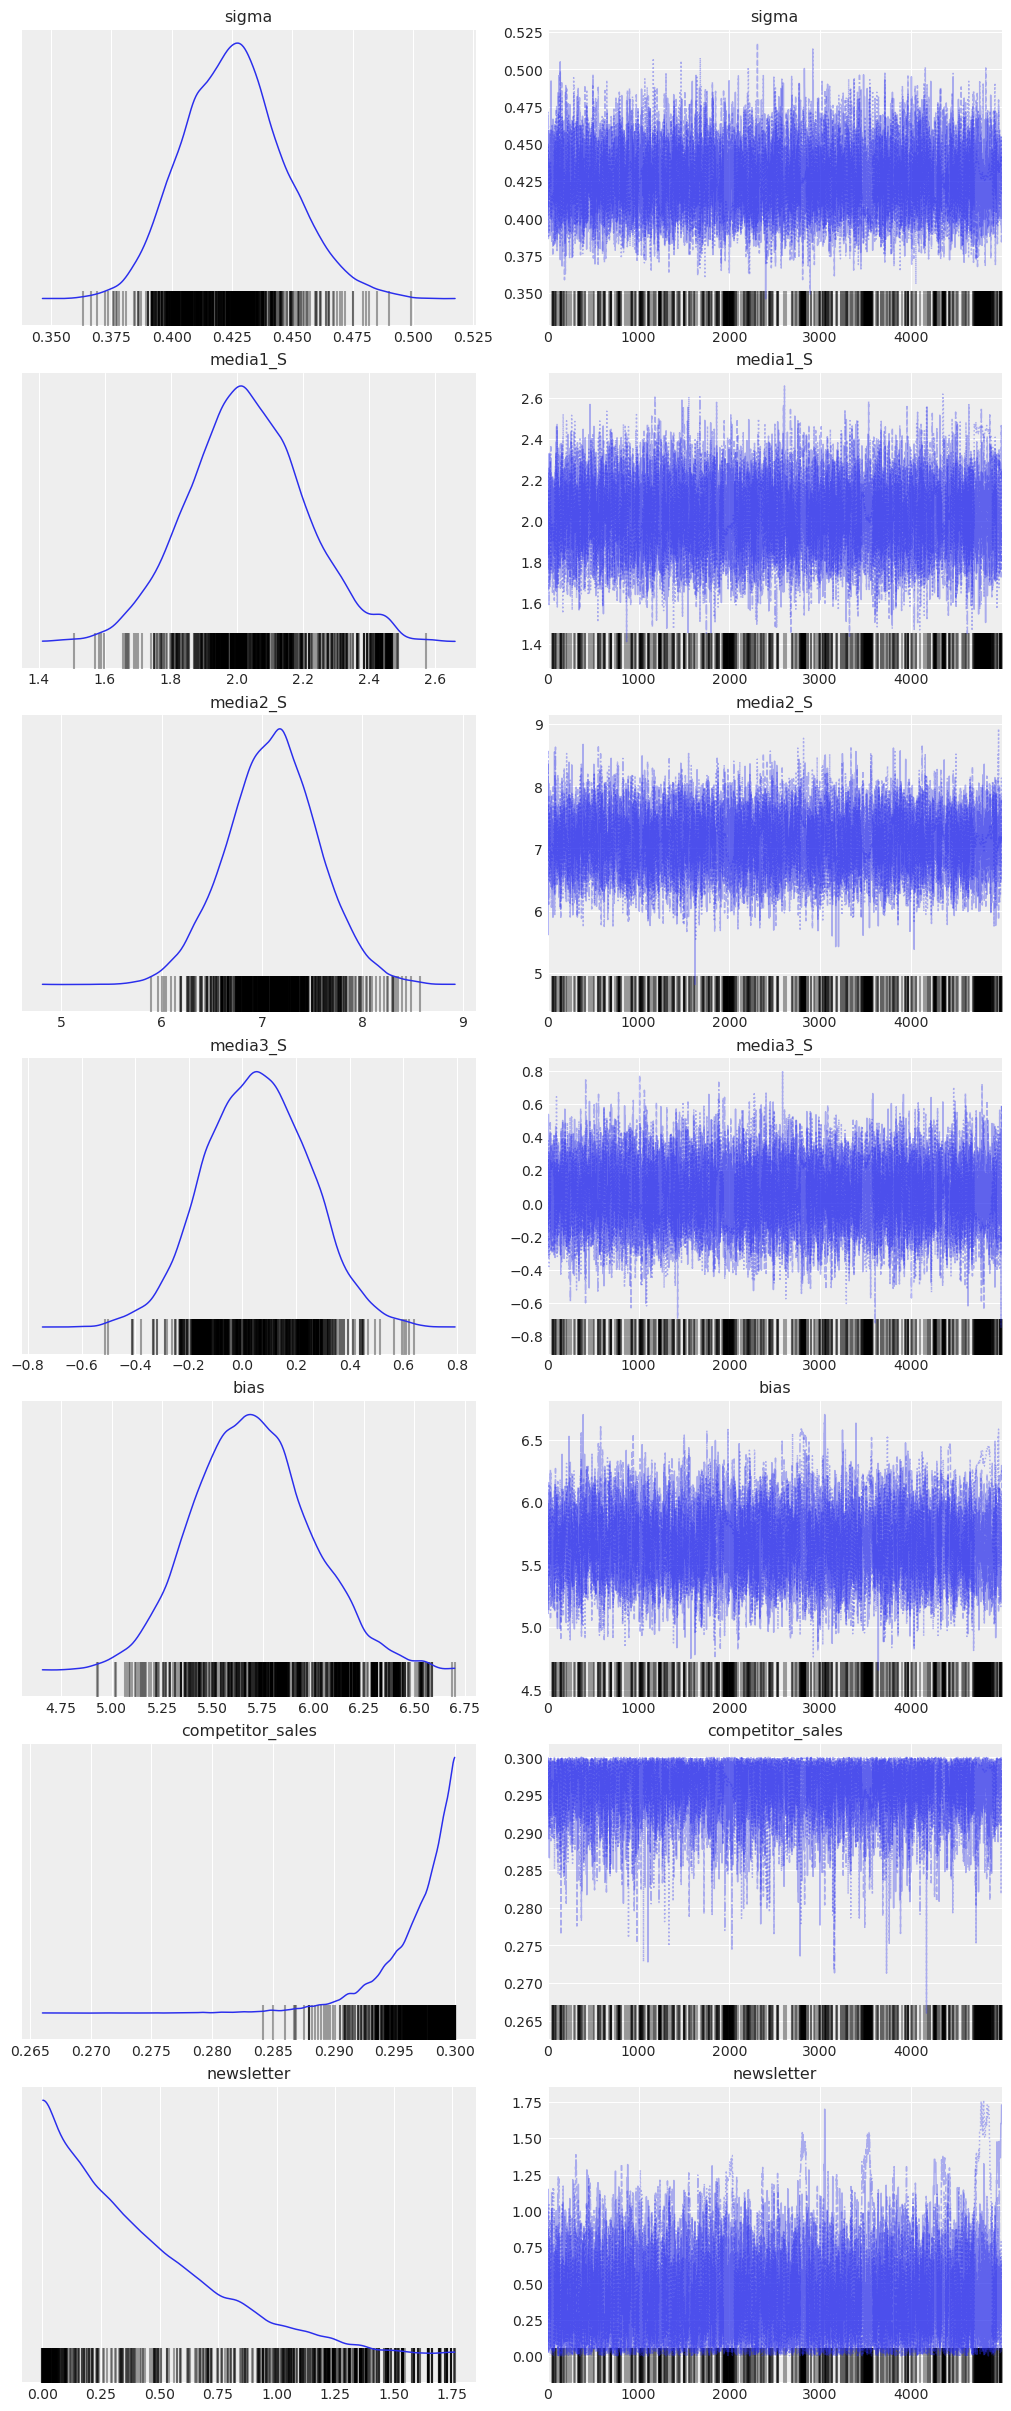

In [26]:
az.plot_trace(trace_3, combined=True, figsize=(10, 24));
save2Vis('knowledge_prior_retrain')

In [ ]:
### closer look

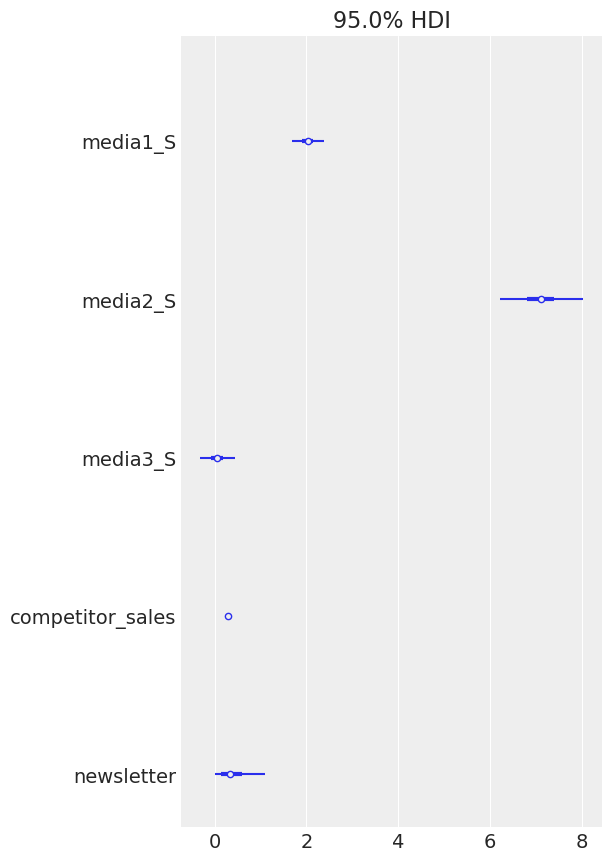

In [34]:
az.plot_forest(trace_3, var_names=["media1_S", "media2_S", "media3_S", "competitor_sales", "newsletter", ], combined=True, hdi_prob=0.95);
save2Vis('posteior_hdi')